Creating data_processor and processing training and testing data...
Creating model and start training...
Train on 85864 samples, validate on 10060 samples
Epoch 1/25
85864/85864 [==============================] - 51s 593us/sample - loss: 0.9963 - accuracy: 0.6574 - val_loss: 1.1288 - val_accuracy: 0.6685
Epoch 2/25
85864/85864 [==============================] - 49s 567us/sample - loss: 0.4694 - accuracy: 0.8572 - val_loss: 1.0516 - val_accuracy: 0.7081
Epoch 3/25
85864/85864 [==============================] - 47s 551us/sample - loss: 0.3164 - accuracy: 0.9077 - val_loss: 1.0578 - val_accuracy: 0.7183
Epoch 4/25
85864/85864 [==============================] - 48s 559us/sample - loss: 0.2560 - accuracy: 0.9259 - val_loss: 1.2003 - val_accuracy: 0.7251
Epoch 5/25
85864/85864 [==============================] - 48s 560us/sample - loss: 0.2096 - accuracy: 0.9397 - val_loss: 1.0491 - val_accuracy: 0.7405
Epoch 6/25
85864/85864 [==============================] - 47s 550us/sample - loss: 0.1763 

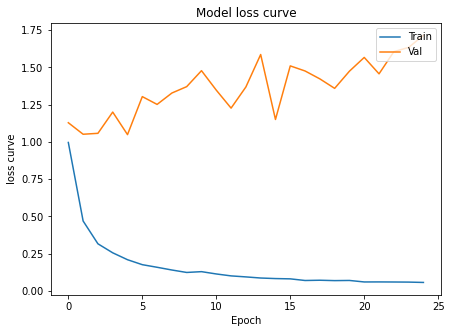

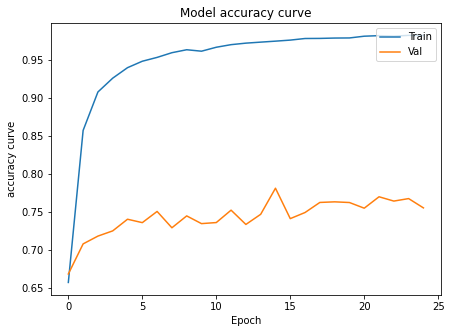

In [19]:
# -*- coding: utf-8 -*-
"""
Created on Sat Nov 28 22:55:07 2020

@author: Mathanraj-Sharma
@email: rvmmathanraj@gmail.com
"""

import sys  
sys.path.append('../') 
from classifiers import LSTM
from utils import data_processor
from utils import reports_generator
from utils import FHW_predictor
from datetime import datetime
import tensorflow.keras as keras
import json

def get_model(model_type, out_dir, kwargs):
    
    if model_type == 'BASE':
        return BASE(output_dir=out_dir, **kwargs)
    elif model_type == 'Simple_CNN':
        return Simple_CNN(output_dir=out_dir, **kwargs)
    elif model_type == 'Multi_Headed_CNN':
        return Multi_Headed_CNN(output_dir=out_dir, **kwargs)
    elif model_type == 'FCN':
        return FCN(output_dir=out_dir, **kwargs)
    elif model_type == 'RESNET':
        return RESNET(output_dir=out_dir, **kwargs)
    elif model_type == 'CNN_LSTM':
        return CNN_LSTM(output_dir=out_dir, **kwargs)
    elif model_type == 'Bi_LSTM':
        return Bi_LSTM(output_dir=out_dir, **kwargs)
    elif model_type == 'LSTM':
        return LSTM(output_dir=out_dir, **kwargs)
    elif model_type == 'GRU':
        return GRU(output_dir=out_dir, **kwargs)
    else:
        raise ValueError('Unknown model specified in params.json')
        
if __name__ == "__main__":
    
    with open('train_params.json', 'r') as file:
        args = json.load(file)
    
    file_name = f"{args['model_type']}-{args['axis']}Axis-{args['hand_combo']}-{args['hand_info']}-{args['other']}-"
    date = datetime.now().strftime("%d-%m-%Y")
    output_directory = f"{args['output_dir']}/{date}/pre_window-{file_name}"+datetime.now().strftime("%d-%m-%Y-%H-%M-%S")+'/'
    
    # load and preprocess train and test data
    print('Creating data_processor and processing training and testing data...')
    data_pro = data_processor(args['input_dir'], output_dir=output_directory)
    data_pro.fit_transform()
    
    X_train = data_pro.X_train
    y_train = data_pro.y_train
    
    X_test =  data_pro.X_test
    y_test = data_pro.y_test
    # create model object and train model
    print('Creating model and start training...')
    model = get_model(args['model_type'], output_directory, args['model_kwargs'])
    model.fit(data_pro.X_train, data_pro.y_train, data_pro.X_test, data_pro.y_test)
    
    # Load saved best model after training
    print('Loading trained best model...')
    if args['model_type'] == "Multi_Headed_CNN":
        model.load_weights(f"{output_directory}/best_model.hdf5")
    else:
        model = keras.models.load_model(f"{output_directory}/best_model.hdf5", compile=False)
    
    # generate reports
    print('Creating reports_generator object and generating reports...')
    rg = reports_generator(model, data_pro, output_dir=output_directory)
    rg.generate_classification_reports(data_pro.X_test, data_pro.y_test)
    rg.generate_individual_report(args['input_dir']+'/test/')
    
    #  generate full handwash reports
    print('Creating FHW_predictor object and generating FHW predictions...')
    fhw = FHW_predictor(model, data_pro, output_dir=output_directory)
    
    # FHW score for old data
    if args['fhw_nolabeled']:
        fhw.record_FHW_predictions(args['fhw_nolabeled_dir'] ,'FHW_predictions_nolabeled', encode_labels=False)
        results = fhw.record_FHW_scores(args['fhw_nolabeled_dir'], file_name='FHW_score_nolabeled')
    
    # FHW score for new labeld data
    if args['fhw_labeled']:
        fhw.record_FHW_predictions(args['fhw_labeled_dir'] ,'FHW_predictions_labeled', encode_labels=True)
        results = fhw.record_FHW_scores(args['fhw_labeled_dir'], file_name='FHW_score_labeled' )
        
    print(f"Completed model training and outputs stored at {output_directory}")
        
    


In [2]:
X_train.shape

(85864, 104, 8)

In [3]:
X_test.shape

(10060, 104, 8)